In [1]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.linalg import cholesky

from pygam import LinearGAM, s, f, te

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
pheno_cols = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

# Load tables

In [3]:
#features = pd.read_hdf("%s/processed/features.hdf" % data_dir)
features = pd.read_csv("%s/processed/adjusted_features.csv" % data_dir,index_col=0)
features.sample(3)

median_0  median_1   upper_0   upper_1   lower_0   lower_1  \
INT_116_5502400 -1.335574  0.428064 -1.161364  0.030162 -1.219175  0.696200   
INT_116_7777600 -0.029694 -0.924971 -0.293226 -1.029394  0.063130 -0.553961   
INT_116_5333300  1.308388  0.675295  0.625469  0.490714  1.747226  0.648741   

                    std_0     std_1     iqr_0     iqr_1  ratio_upper  \
INT_116_5502400 -0.671760 -1.195931 -0.990737 -1.547568     1.238336   
INT_116_7777600 -0.587284 -1.214954 -0.315610 -0.892562    -0.103045   
INT_116_5333300 -0.074948 -0.544993  0.052473 -0.672107    -0.585972   

                 ratio_lower  ratio_std  std_2_high  std_2_low  \
INT_116_5502400     1.072379   0.004403    0.049603  -2.192078   
INT_116_7777600    -0.488791  -0.140979   -0.952510  -1.306309   
INT_116_5333300    -0.387074  -0.261816   -1.266700  -0.038736   

                 days_since_start  machine  
INT_116_5502400               568      2.0  
INT_116_7777600               629      1.0  
INT_116_5333300               523      2.0

In [4]:
cohorts = pd.read_hdf("%s/processed/cohorts.hdf" % data_dir,key="cohorts")
cohorts.sample(3)

SampleNo  cohort
5073.0   INT_116_4726400      21
NaN      INT_116_6948800      -1
17736.0  INT_116_5226800      31

In [5]:
phenotypes = pd.read_csv("%s/processed/phenotypes.csv" % data_dir,index_col=0).set_index("SAMPLE_ID")
phenotypes = phenotypes[pheno_cols]
phenotypes.sample(3)

ADP_PSEL   ADP_FIB       ADP  CRP_PSEL   CRP_FIB       CRP  \
SAMPLE_ID                                                               
C19W5K     1.852257  0.491465  1.171861  1.539332  1.294772  1.417052   
C18A63    -0.241237  0.791316  0.275040 -0.201312  0.012734 -0.094289   
C18GRB    -1.303056  0.298753 -0.502151 -0.795014 -0.146006 -0.470510   

           TRAP_PSEL  TRAP_FIB      TRAP  PAR1_PSEL  PAR1_FIB      PAR1  \
SAMPLE_ID                                                                 
C19W5K      3.018390  1.772422  2.395406   2.306002  1.360456  1.833229   
C18A63     -0.068506  0.872084  0.401789   0.328067  0.988349  0.658208   
C18GRB     -2.116738 -0.959696 -1.538217  -2.582731 -1.131262 -1.856997   

           PAR4_PSEL  PAR4_FIB      PAR4  
SAMPLE_ID                                 
C19W5K      1.759804  0.817901  1.288852  
C18A63      0.545884  1.230881  0.888382  
C18GRB     -2.027819 -0.659475 -1.343647

In [6]:
#sysmex_features_adj = pd.read_csv("%s/processed/sysmex_features.csv" % data_dir,index_col=0)
sysmex_features = pd.read_csv("%s/processed/sysmex_features_unadjusted.csv" % data_dir,index_col=0)
sysmex_features.sample(3)

PLT   MPV   PDW   PCT       IPF
INT_116_3308700  235.0  11.8  14.5  0.29  0.301030
INT_116_608300   214.0  12.6  16.5  0.26  0.812913
INT_116_937800   193.0  11.7  15.0  0.22  0.732394

In [7]:
sys_agesex, int_agesex = get_ages_sex()
agesex = pd.concat((sys_agesex,int_agesex),axis=0)

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


# Merge them

In [8]:
print(agesex.shape[0])
print(sysmex_features.shape[0])
covars = pd.merge(agesex, sysmex_features,left_index=True,right_index=True,how="inner")

32922
31360


In [9]:
covars = pd.merge(covars, cohorts.set_index("SampleNo"),left_index=True,right_index=True,how="inner")
print(covars.shape[0])
covars.sample(3)

31355


SEX   AGE    PLT   MPV   PDW   PCT       IPF  cohort
INT_116_2497700    2  43.8  249.0  11.7  15.6  0.18  0.397940      27
INT_116_733000     2  25.8  312.0  11.5  14.5  0.35  0.724276      39
INT_116_1034400    2  47.8  419.0  10.9  13.4  0.45  0.414973      39

In [10]:
print(features.shape[0])
X_all = pd.merge(covars, features,left_index=True,right_index=True)
print(X_all.shape[0])

31320
31313


In [11]:
X_all.sample(3)

SEX   AGE    PLT   MPV   PDW   PCT       IPF  cohort  \
INT_116_5388800    2  65.6  185.0  13.1  20.7  0.23  1.025306      16   
INT_116_2461200    2  28.7  244.0  12.5  15.1  0.30  0.579784       9   
INT_116_567800     1  51.9  189.0  11.6  14.4  0.23  0.477121      30   

                 median_0  median_1  ...     std_1     iqr_0     iqr_1  \
INT_116_5388800  1.662637  0.765722  ...  1.051236  2.615970  1.318292   
INT_116_2461200  0.899198  0.593190  ...  0.212727 -0.541338 -0.140040   
INT_116_567800   0.048960  0.071867  ...  0.127411  0.516513  0.182234   

                 ratio_upper  ratio_lower  ratio_std  std_2_high  std_2_low  \
INT_116_5388800    -1.504098    -1.439810  -1.896800    0.864539   0.886406   
INT_116_2461200    -0.478706     0.637639   0.470650    0.113363   0.717718   
INT_116_567800      0.066147    -1.384379  -0.142425    0.074495   0.133351   

                 days_since_start  machine  
INT_116_5388800               537      2.0  
INT_116_2461200               244      2.0  
INT_116_567800                333      1.0  

[3 rows x 25 columns]

In [12]:
covar_cols = covars.columns
#features_cols = ["upper_0","mean_1","ratio_lower"]
#features_cols = ["median_1","mean_0","lower_1","std_1","iqr_1","ratio_upper"]
#features_cols = ["upper_0","mean_1","lower_1","iqr_0","ratio_lower","mean_0"]
features_cols = features.columns
#features_cols = ["lower_0","upper_0","std_0","iqr_0","ratio_upper","ratio_lower","ratio_std","PC_0","PC_1","PC_2","PC_4"]

# Prepare cofactors for adjustment

In [13]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


In [14]:
int_phen["days_since_start"] = (int_phen.day - int_phen.day.min()).dt.days

#int_phen["log_ht"] = np.log10(int_phen["ht_bl"])
#int_phen["log_wt"] = np.log10(int_phen["wt_bl"])

#int_phen["smFreq_bl"].value_counts()
#int_phen["smoking_freq"] = int_phen["smFreq_bl"]
#int_phen["smoking_time"] = int_phen[["smCig_bl","smCigar_bl","smPipe_bl"]].max(skipna=True)
#int_phen.loc[int_phen.smoking_freq.isnull(),"smoking_freq"] = 0.
#int_phen.loc[int_phen.smoking_time.isnull(),"smoking_time"] = 0.

In [15]:
sys_phen = load_sys_phenotypes(data_dir)
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"],format="%d/%m/%Y")
sys_phen["days_since_start"] = (sys_phen["time_col"] - int_phen.day.min()).dt.days
sys_phen["yearday"] = sys_phen["time_col"].dt.dayofyear
sys_phen["hours"] = sys_phen.Time.str[:2].astype(int)
sys_phen.rename(columns={"ID":"SampleNo"},inplace=True)

phen = pd.concat([int_phen,sys_phen],axis=0)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


In [16]:
comp = pd.merge(X_all.reset_index().rename(columns={"index":"SampleNo"}),
                phen[[c for c in phen.columns if c not in X_all.columns]],left_on="SampleNo",right_on="SampleNo",how="left")

In [17]:
max_days_since_start = 640
delete_last_days = True
# This was added after I remarked that last values of IPF are nuts (much more variance than elsewhere)

In [18]:
comp["DateTime"] = pd.to_datetime(comp["DateTime"])
comp = comp.sort_values(["Instrument","days_since_start"])
comp.replace({"Instrument":{"XN-10^11036":0,"XN-10^11041":1,np.nan:2}}
             ,inplace=True)

if delete_last_days:
    before_cut_shape = comp.shape[0]
    comp = comp.loc[(comp.Instrument == 2) | (comp.days_since_start <= max_days_since_start)]
    after_cut_shape = comp.shape[0]
    print("%d -> %d" % (before_cut_shape, after_cut_shape))
    
comp["rank"] = np.arange(comp.shape[0])
comp = comp.set_index("SampleNo")

comp["SEX_menopause"] = comp["menopause_bl"]
comp.loc[comp.SEX == 1,"SEX_menopause"] = 0
comp.loc[comp.SEX_menopause.isnull(),"SEX_menopause"] = 999

#comp.loc[comp.smoking_freq.isnull(),"smoking_freq"] = -1
#comp["smoking_freq"].value_counts()


comp["hours"] = comp["hours"].astype(float)
comp["yearday"] = comp["yearday"].astype(float)

31313 -> 28850


In [19]:
sysmex_covariates = ["PLT","MPV","PCT","PDW","IPF"]

# Adjust for experimental artifacts

In [20]:
to_adjust_technically = sysmex_covariates #+ list(features_cols)

In [21]:
to_adjust_technically

['PLT', 'MPV', 'PCT', 'PDW', 'IPF']

In [22]:
comp["cohort_training"] = comp["cohort"]
comp.loc[~comp.index.str.contains("INT_116"),"cohort_training"] = -1

In [23]:
from sklearn.preprocessing import quantile_transform, scale

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PLT


100% (11 of 11) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


OrderedDict([('explained_deviance', 0.014919329066531928), ('McFadden', 0.9999997476278495), ('McFadden_adj', -0.0001687821137477119)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

MPV


100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


OrderedDict([('explained_deviance', 0.0540272759734205), ('McFadden', 0.9770060528181949), ('McFadden_adj', 0.02190011298092487)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PCT


100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


OrderedDict([('explained_deviance', 0.03608336842879678), ('McFadden', 0.9627778368211314), ('McFadden_adj', 0.03720917152868575)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PDW


100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


OrderedDict([('explained_deviance', 0.046860009137469905), ('McFadden', 0.9980248522455596), ('McFadden_adj', 0.0013870998132927692)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

IPF


100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


OrderedDict([('explained_deviance', 0.10862041054939575), ('McFadden', 0.8645091398224165), ('McFadden_adj', 0.13529656969716908)])


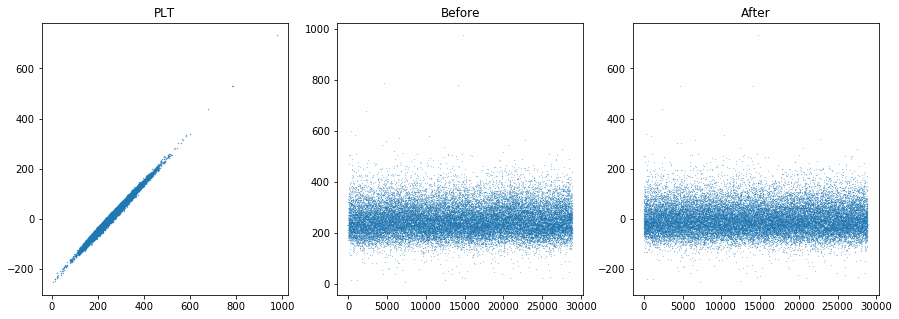

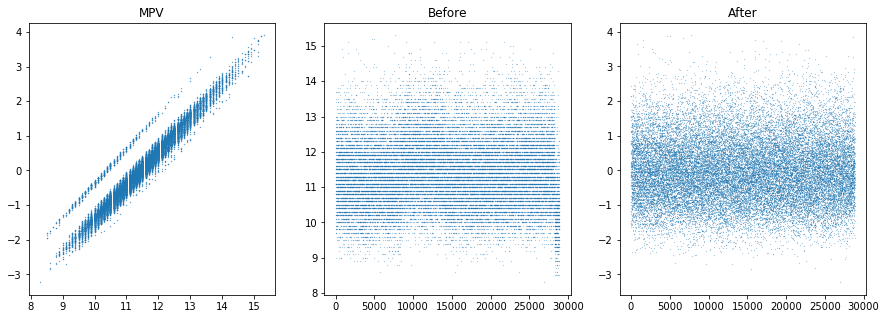

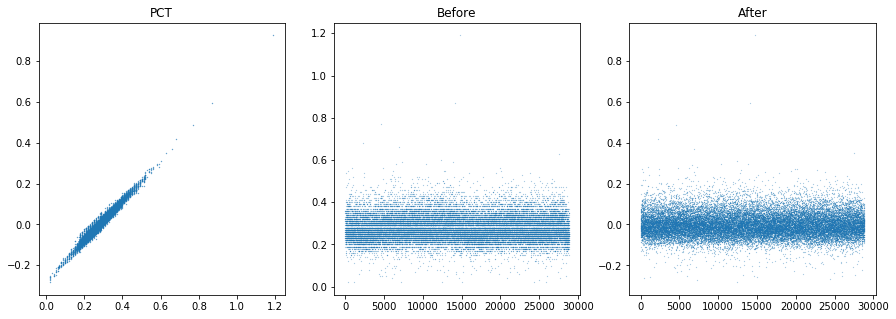

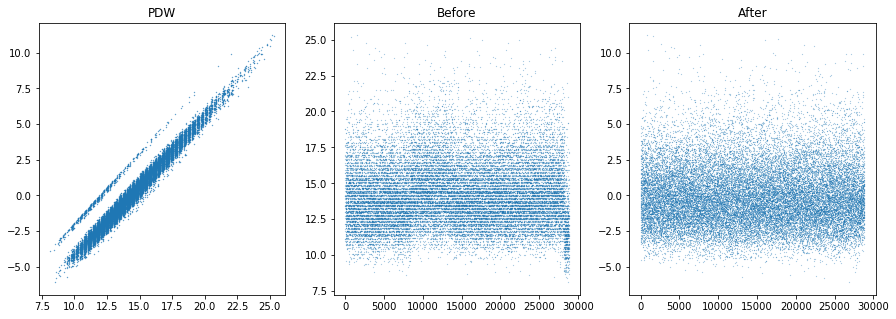

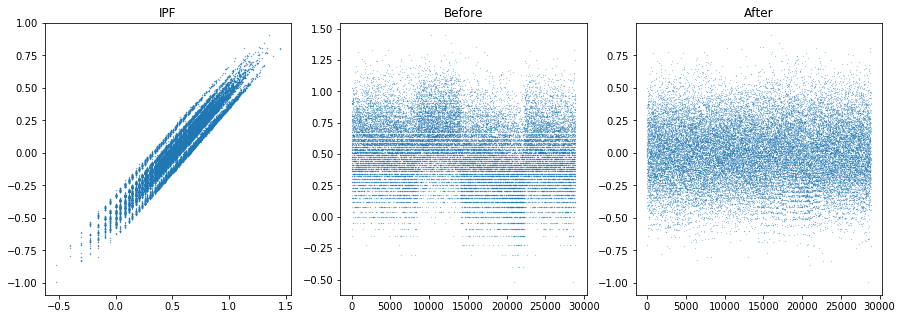

In [24]:
X = comp[["Instrument","cohort_training","hours","AGE","SEX_menopause","yearday","days_since_start"]].copy()

def index_of(column):
    for i, c in enumerate(X.columns):
        if c == column:
            return i

from pygam import LinearGAM, s, f, te
        
# Option : sans age/sex
#gam = LinearGAM(te(f(index_of("Instrument")),f(index_of("cohort"))) + \
#          te(s(index_of("hours")),f(index_of("Instrument"))) + \
#          s("yearday",basis="cp") + f(index_of("Instrument")))

# Option : avec age/sex (prennant en compte que les cohortes ne sont pas uniformes)

gams = {}

for col in to_adjust_technically:

    gam = LinearGAM(f(index_of("cohort_training")) + \
                    te(s(index_of("hours"),n_splines=5),f(index_of("cohort_training"))) + \
                    te(s(index_of("AGE"),n_splines=5),f(index_of("SEX_menopause"))))
    
    Y = comp[col]
    print(col)
    # CENTRAL is new. Does it work ?
    #central = (Y < Y.quantile(0.9)) & (Y > Y.quantile(0.1))
    #gam.gridsearch(X.loc[central].values,Y.loc[central])
    gam = gam.gridsearch(X.values,Y)
    gams[col] = gam
    
    #print(gam.statistics_["p_values"])
    print(gam.statistics_["pseudo_r2"])
    
    Y_pred = gam.predict(X)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,3,1)
    plt.scatter(Y,Y-Y_pred,s=.1)
    plt.title(col)
    
    ax = fig.add_subplot(1,3,2)
    plt.scatter(comp["rank"],Y,s=.02)
    plt.title("Before")
    
    ax = fig.add_subplot(1,3,3)
    plt.scatter(comp["rank"],Y-Y_pred,s=.02)
    plt.title("After")
    
    comp["%s_raw" % col] = comp[col].copy() 
    comp["%s_tech" % col] = Y - Y_pred

for col in to_adjust_technically:
    comp = comp.loc[(comp["%s_tech" % col] - comp["%s_tech" % col].median()).abs() < 4*comp["%s_tech" % col].std()]
    #comp["%s_tech" % col] = np.clip(comp["%s_tech" % col],
    #                                a_min = comp["%s_tech" % col].median() - 3*comp["%s_tech" % col].std(),
    #                                a_max = comp["%s_tech" % col].median() + 3*comp["%s_tech" % col].std())

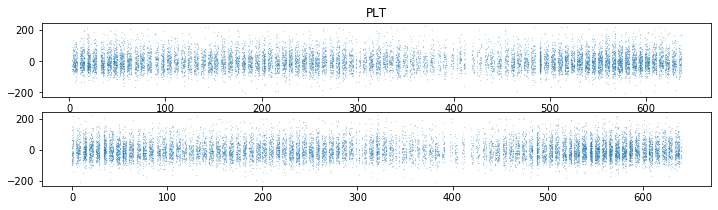

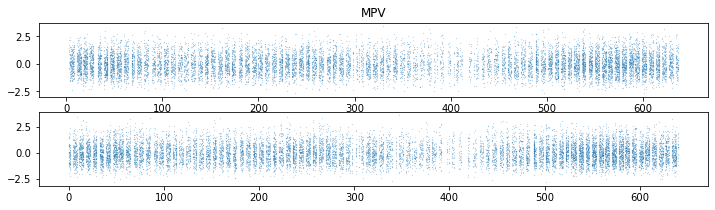

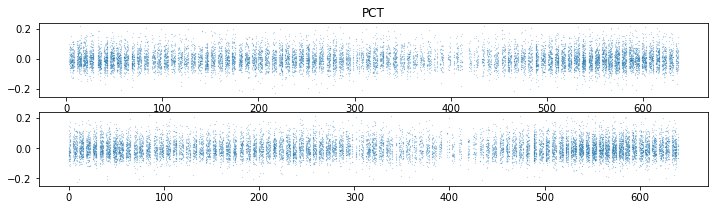

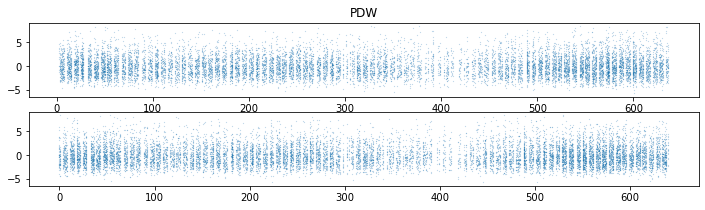

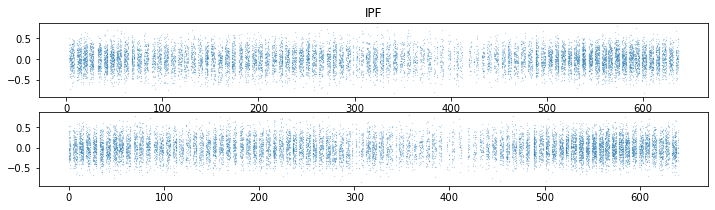

In [25]:
for col in to_adjust_technically:
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(211)
    plt.title(col)
    ax.scatter(comp.loc[comp.machine == 1].days_since_start,
               comp.loc[comp.machine == 1,"%s_tech" % col],s=.01)
    ax = fig.add_subplot(212)
    ax.scatter(comp.loc[comp.machine == 2].days_since_start,
               comp.loc[comp.machine == 2,"%s_tech" % col],s=.01)

In [26]:
import scipy
def get_t_stat(values):
    return scipy.stats.ttest_1samp(values,0)[1]

In [27]:
p_values = comp.groupby(["machine","days_since_start"])[["%s_tech" % col for col in to_adjust_technically]].agg(get_t_stat)
weird = (p_values < 1e-3).sum(axis=1) > 2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

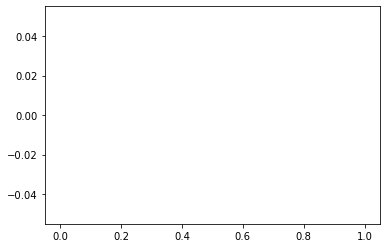

In [28]:
w = pd.DataFrame(weird).reset_index()
plt.hist(w.loc[(w.machine == 1) & w[0] ,"days_since_start"])
plt.hist(w.loc[(w.machine == 2) & w[0] ,"days_since_start"])

In [29]:
n_weird_days = weird.sum()
print("%d weird days" % n_weird_days)
weird_samples = comp.reset_index().set_index(["machine","days_since_start"]).loc[weird.loc[weird].index].SampleNo.tolist()
print("%d people removed" % len(weird_samples))
comp = comp.loc[~comp.index.isin(weird_samples)]

0 weird days
0 people removed


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PLT


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


OrderedDict([('explained_deviance', 0.016983151125043783), ('McFadden', 0.9999996895644901), ('McFadden_adj', -0.00018776179974810958)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

MPV


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


OrderedDict([('explained_deviance', 0.05698323720800247), ('McFadden', 0.9749219711245148), ('McFadden_adj', 0.02386315193062072)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PCT


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


OrderedDict([('explained_deviance', 0.038541017811819955), ('McFadden', 0.9603140724451525), ('McFadden_adj', 0.03967261643852582)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

PDW


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


OrderedDict([('explained_deviance', 0.05015069475859224), ('McFadden', 0.9977563398970912), ('McFadden_adj', 0.0015849413472899254)])


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

IPF


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


OrderedDict([('explained_deviance', 0.11218939686941354), ('McFadden', 0.8604660208365558), ('McFadden_adj', 0.1393243787674453)])


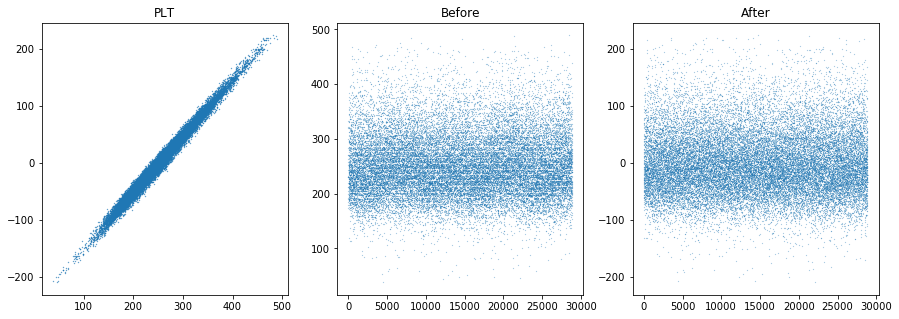

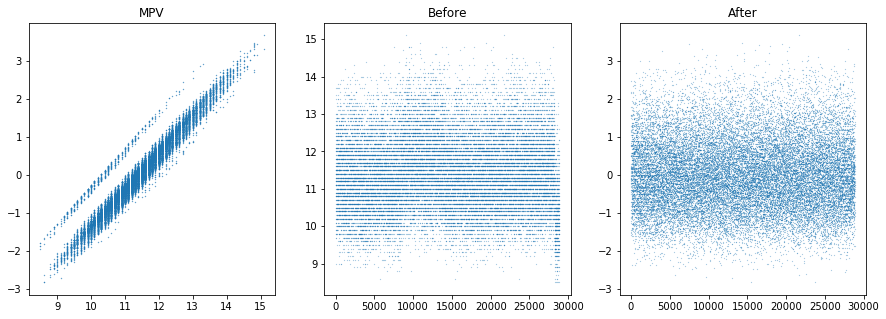

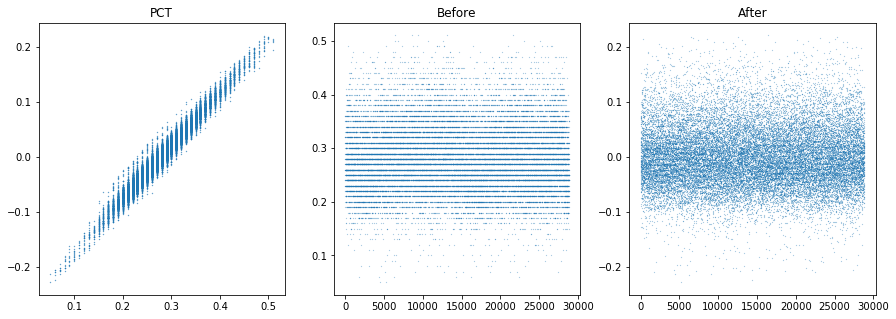

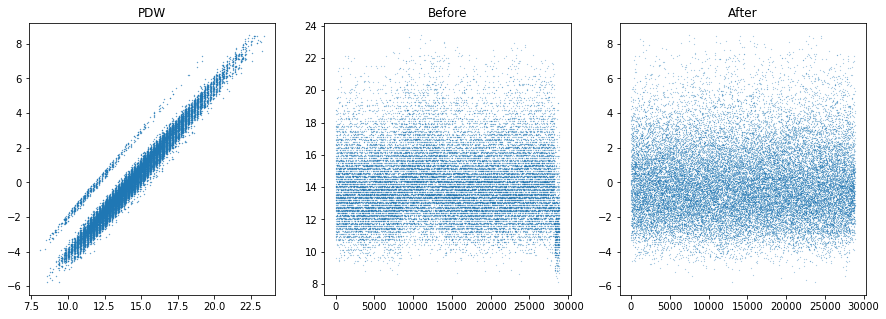

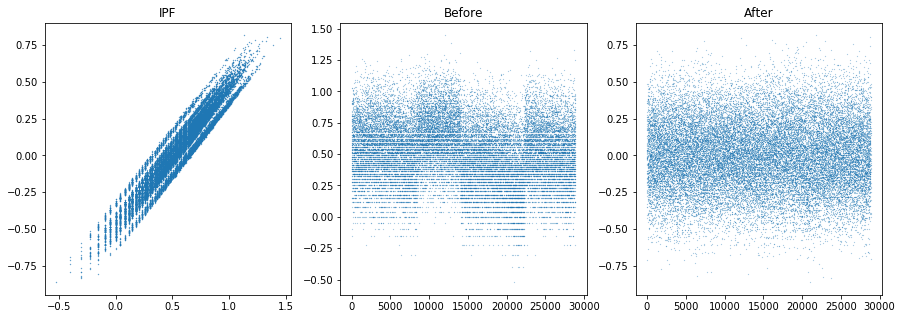

In [30]:
# On refait l'analyse, sans les jours bizarres

X = comp[["Instrument","cohort_training","hours","AGE","SEX_menopause","yearday","days_since_start"]].copy()

def index_of(column):
    for i, c in enumerate(X.columns):
        if c == column:
            return i

from pygam import LinearGAM, s, f, te
        
# Option : sans age/sex
#gam = LinearGAM(te(f(index_of("Instrument")),f(index_of("cohort"))) + \
#          te(s(index_of("hours")),f(index_of("Instrument"))) + \
#          s("yearday",basis="cp") + f(index_of("Instrument")))

# Option : avec age/sex (prennant en compte que les cohortes ne sont pas uniformes)

gams = {}

for col in to_adjust_technically:

    #gam = LinearGAM(te(f(index_of("Instrument")),s(index_of("cohort_training"),n_splines=20)) + \
    #      te(s(index_of("hours"),n_splines=5),f(index_of("Instrument"))) + \
    #            te(s(index_of("AGE"),n_splines=10),f(index_of("SEX_menopause"))) + \
    #      s(index_of("yearday"),basis="cp") + f(index_of("Instrument")))
    gam = LinearGAM(f(index_of("cohort_training")) + \
                    te(s(index_of("hours"),n_splines=5),f(index_of("cohort_training"))) + \
                    te(s(index_of("AGE"),n_splines=10),f(index_of("SEX_menopause"))))
    
    Y = comp[col]
    print(col)
    # CENTRAL is new. Does it work ?
    #central = (Y > np.quantile(Y,0.1)) & (Y < np.quantile(Y,0.9))
    #gam.gridsearch(X.loc[central].values,Y.loc[central])
    gam.gridsearch(X.values,Y)
    gams[col] = gam
    
    #print(gam.statistics_["p_values"])
    print(gam.statistics_["pseudo_r2"])
    
    Y_pred = gam.predict(X)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,3,1)
    plt.scatter(Y,Y-Y_pred,s=.1)
    plt.title(col)
    
    ax = fig.add_subplot(1,3,2)
    plt.scatter(comp["rank"],Y,s=.02)
    plt.title("Before")
    
    ax = fig.add_subplot(1,3,3)
    plt.scatter(comp["rank"],Y-Y_pred,s=.02)
    plt.title("After")
    
    comp["%s_raw" % col] = comp[col].copy() 
    comp["%s_tech" % col] = Y - Y_pred

for col in to_adjust_technically:
    comp = comp.loc[(comp["%s_tech" % col] - comp["%s_tech" % col].median()).abs() < 4*comp["%s_tech" % col].std()]

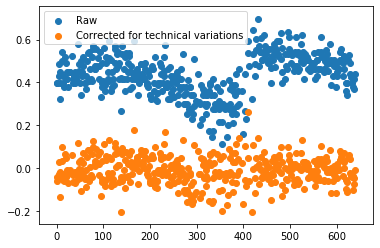

In [31]:
to_check = comp.loc[comp.machine == 2].groupby("days_since_start")["IPF_raw"].median()
plt.scatter(to_check.index,to_check,label="Raw")
to_check = comp.loc[comp.machine == 2].groupby("days_since_start")["IPF_tech"].median()
plt.scatter(to_check.index,to_check,label="Corrected for technical variations")
plt.legend()

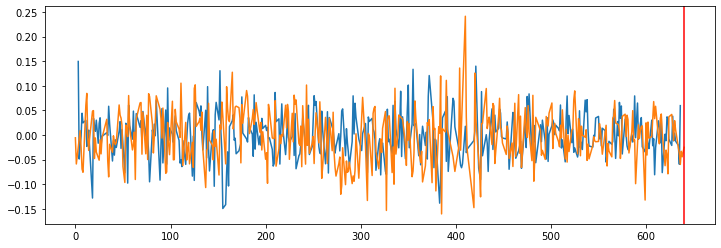

In [32]:
plt.figure(figsize=(12,4))
plt.plot(comp.loc[comp.machine == 1].groupby("days_since_start")[["IPF_tech"]].mean())
plt.plot(comp.loc[comp.machine == 2].groupby("days_since_start")[["IPF_tech"]].mean())
plt.axvline(max_days_since_start,c="red")

In [33]:
def get_r2(df):
    dic = {}
    for c in to_adjust_technically:
        r, p = pearsonr(df["%s_tech" % c],df["%s_raw" % c])
        dic[c] = 1.-r**2
    return pd.Series(dic)
        
comp.groupby("cohort_training").apply(get_r2).mean(axis=1)

cohort_training
-1     0.032438
 5     0.009347
 6     0.007858
 7     0.007471
 8     0.006708
 9     0.007230
 10    0.005613
 11    0.007753
 12    0.006735
 13    0.010594
 14    0.007387
 15    0.008339
 16    0.008883
 17    0.008202
 18    0.007774
 20    0.009302
 21    0.008599
 22    0.007994
 23    0.006920
 24    0.005409
 25    0.005647
 26    0.007708
 27    0.008263
 28    0.006500
 29    0.007940
 30    0.006934
 31    0.007163
 32    0.015030
 33    0.007243
 34    0.007179
 35    0.010705
 36    0.008215
 37    0.008375
 38    0.007649
 39    0.004114
dtype: float64

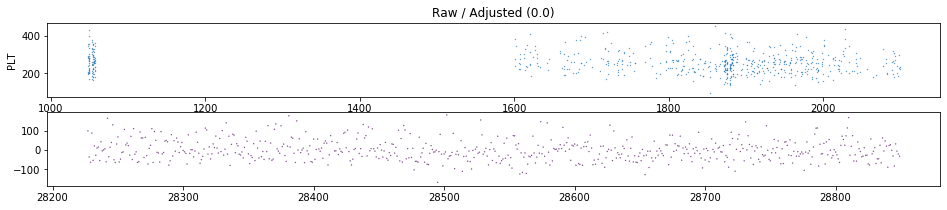

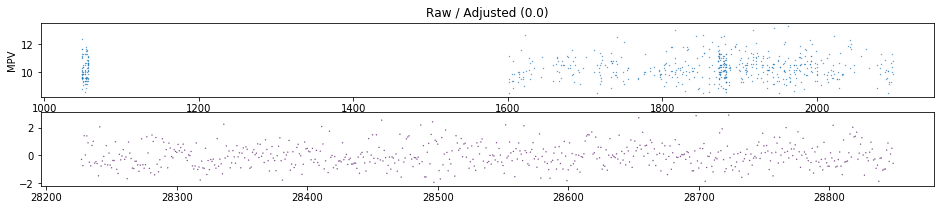

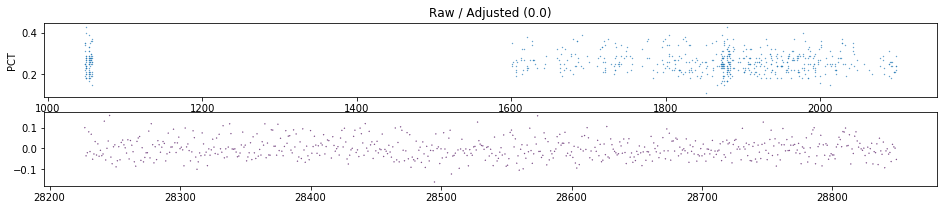

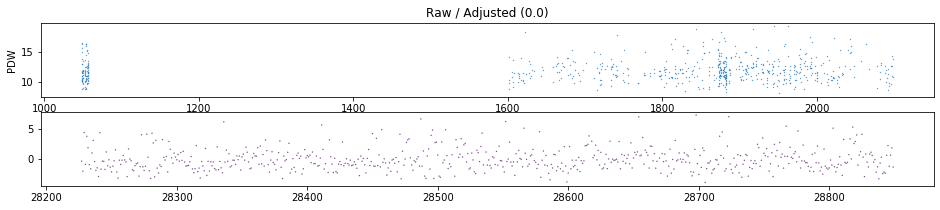

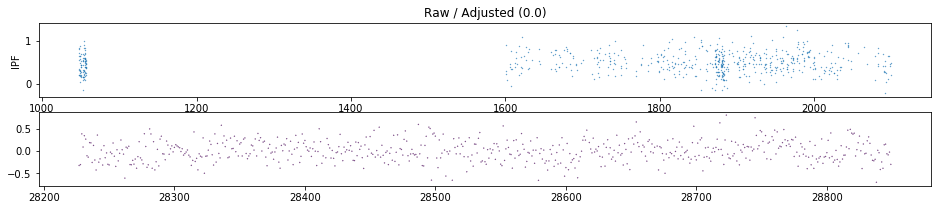

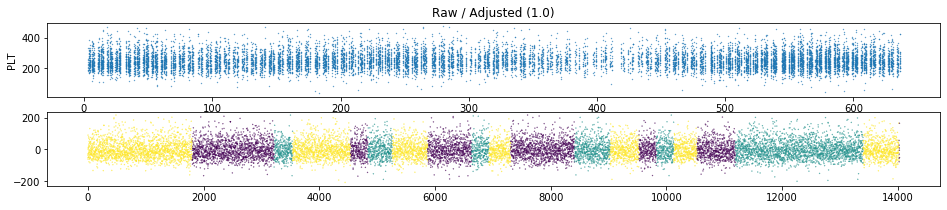

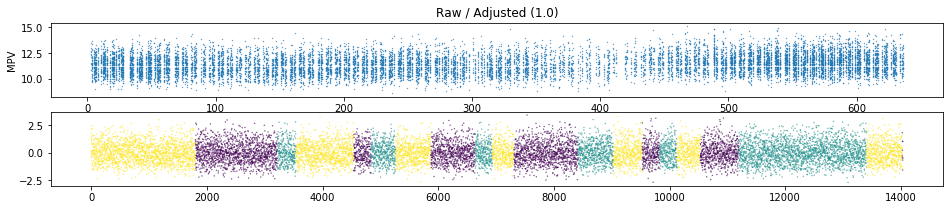

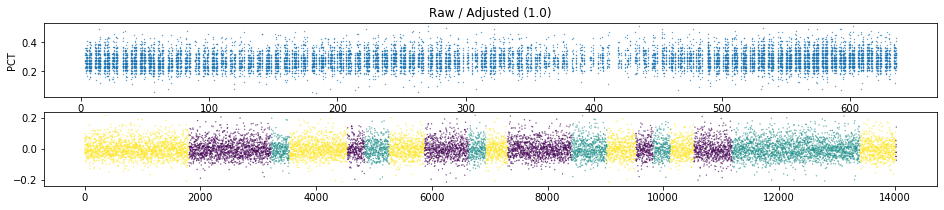

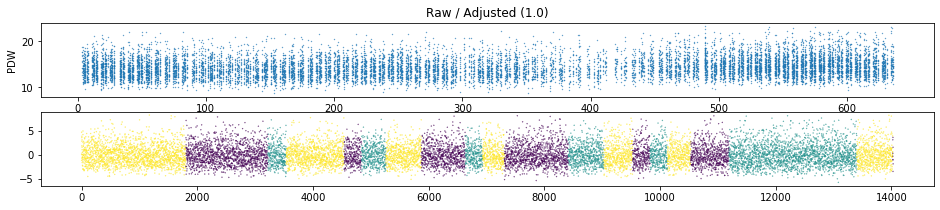

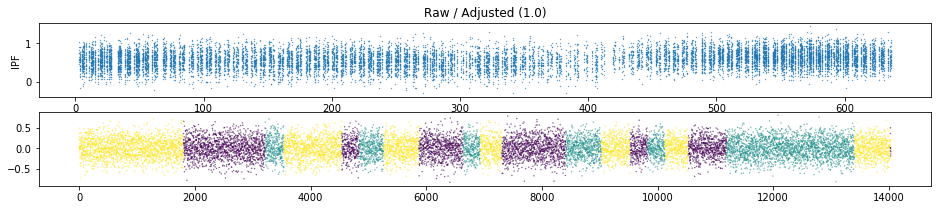

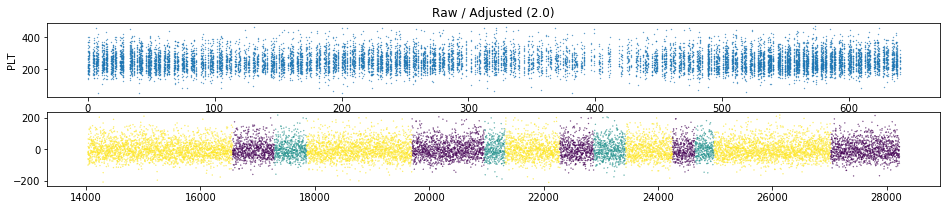

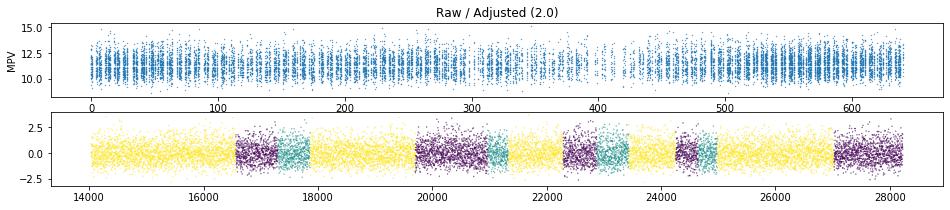

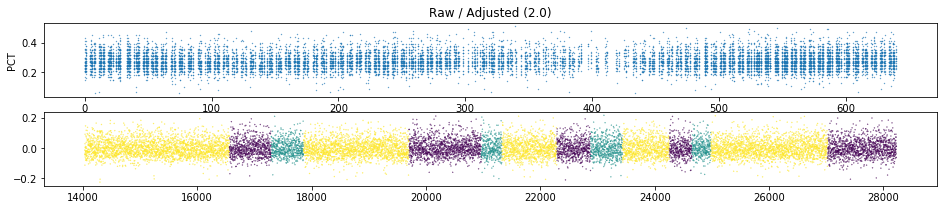

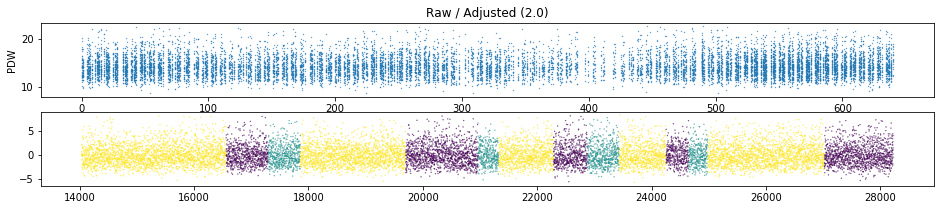

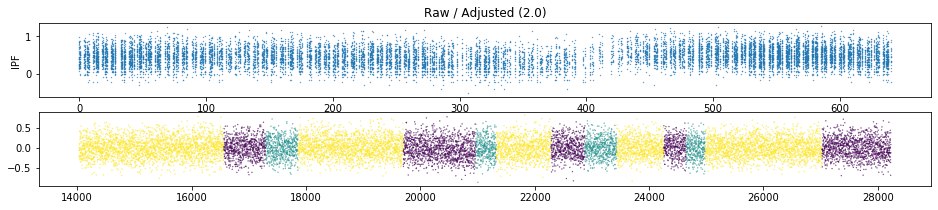

In [34]:
for machine, comp_ in comp.groupby("machine"):

    for col in to_adjust_technically:
        fig = plt.figure(figsize=(16,3))
        ax = fig.add_subplot(211)
        ax.set_title("Raw / Adjusted (%s)" % machine)
        ax.scatter(comp_["days_since_start"], comp_["%s_raw"%col],s=.1)
        ax.set_ylabel(col)
        ax = fig.add_subplot(212)
        plt.scatter(comp_["rank"], comp_["%s_tech" % col],s=.1,c=comp_["cohort_training"] % 3)

In [35]:
for c in to_adjust_technically:
    X_all.loc[comp.index,c] = comp["%s_tech" % c]
X_all = X_all.loc[comp.index]
X_all["cohort_all"] = 0

In [36]:
X_all_init = X_all.copy()

# Gather all other variables for training

In [37]:
X_all = X_all_init.copy()

In [38]:
X_all.head()

SEX   AGE        PLT       MPV       PDW       PCT       IPF  \
SampleNo                                                                        
INT_116_2126200    1  20.8 -35.985095  0.052712  0.135685 -0.014014 -0.068131   
INT_116_2126400    1  28.5 -60.119994  2.137563  4.692614  0.003808  0.202478   
INT_116_146000     2  56.4  89.843879 -0.335530 -1.180561  0.096582  0.038267   
INT_116_146200     2  61.5 -28.559136  1.482142  1.865703  0.009411  0.212069   
INT_116_2126800    1  34.4 -50.940294  1.289207  3.591908 -0.005440  0.356224   

                 cohort  median_0  median_1  ...     iqr_0     iqr_1  \
SampleNo                                     ...                       
INT_116_2126200      20 -0.194143 -0.445042  ... -0.282391 -0.167765   
INT_116_2126400      20  0.000146 -1.602571  ...  0.534397  0.892840   
INT_116_146000       20  0.446794 -0.161986  ... -0.852662 -0.153168   
INT_116_146200       20  1.101397 -0.727026  ...  0.169691  0.462424   
INT_116_2126800      20  0.904717  0.103502  ...  1.340878  0.868374   

                 ratio_upper  ratio_lower  ratio_std  std_2_high  std_2_low  \
SampleNo                                                                      
INT_116_2126200     0.139466     0.113775   0.316329   -0.291607   1.297125   
INT_116_2126400    -0.456354    -0.023353   0.448738    0.723280   2.663110   
INT_116_146000     -0.136769     0.670050   0.232313   -0.351292  -0.911710   
INT_116_146200     -0.780400    -0.322825  -0.071757    0.652277  -0.157453   
INT_116_2126800    -0.670432    -1.157253   0.063678    1.440818   2.190305   

                 days_since_start  machine  cohort_all  
SampleNo                                                
INT_116_2126200                 3      1.0           0  
INT_116_2126400                 3      1.0           0  
INT_116_146000                  3      1.0           0  
INT_116_146200                  3      1.0           0  
INT_116_2126800                 3      1.0           0  

[5 rows x 26 columns]

In [39]:
X_all = pd.merge(X_all,phenotypes,left_index=True,right_index=True,how="left")

In [40]:
data_home = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [41]:
pear1_int = pd.read_csv("%s/PEAR1_INTERVAL.csv" % data_home,index_col=0).set_index("SampleNo")
pear1_pfc = pd.read_csv("%s/PEAR1_PFC.csv" % data_home,index_col=0).set_index("ID")

In [42]:
pear1 = pd.concat([pear1_int,pear1_pfc])

In [43]:
X_all = pd.merge(X_all,pear1,left_index=True,right_index=True,how="left")

In [44]:
X_all.shape

(28669, 42)

In [45]:
PCs = pd.read_csv("%s/PCs_INTERVAL.csv" % data_home,index_col=0).set_index("SampleNo")

In [46]:
PCs.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
SampleNo                                                                      
INT_116_4947100  0.001051 -0.005030  0.000366 -0.000485  0.003907 -0.001036   
INT_116_2392500 -0.000064 -0.000603  0.000856  0.006369 -0.002127  0.006433   
INT_116_6648700  0.001009  0.004312 -0.009543  0.008209  0.002722  0.004606   
INT_116_6648600  0.006815  0.000915  0.006795 -0.005582 -0.005617  0.001646   
INT_116_230200   0.006833  0.003003  0.002493  0.000562  0.008410  0.002672   

                      PC7       PC8       PC9      PC10  
SampleNo                                                 
INT_116_4947100  0.003214  0.007618 -0.000403 -0.004247  
INT_116_2392500  0.001969 -0.000814 -0.000623  0.001776  
INT_116_6648700  0.004591  0.006361  0.002414  0.001101  
INT_116_6648600  0.000007  0.000766  0.007461  0.002496  
INT_116_230200   0.010753  0.005626  0.001188  0.000879

In [47]:
X_all = pd.merge(X_all,PCs,left_index=True,right_index=True,how="left")

In [48]:
X_all = pd.merge(X_all,comp[["Instrument","days_since_start"]],left_index=True,right_index=True,how="left")

In [49]:
X_all.to_csv("%s/processed/X_all.csv" % data_dir)

In [50]:
# 5K donors less when we filter out extreme values !

In [51]:
X_all.shape

(28669, 54)